# Aphid-Ladybeetle study

In [1]:
import copy
import numpy as np  # linear algebra
from numba import jit

import arviz as az
from arviz.utils import Numba
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd
import pymc3 as pm  # for uncertainty quantification and model calibration
import theano  # to control better pymc3 backend and write a wrapper
import theano.tensor as t  # for the wrapper to a custom model to pymc3
import time
from tqdm.autonotebook import tqdm
import warnings
import sys

np.seterr('warn')
warnings.filterwarnings("ignore")
az.style.use("default")#,"arviz-colors")
#az.style.use("arviz-darkgrid")

Numba.enable_numba()

seed=1234
np.random.seed(seed)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/tmp/ipykernel_69447/3528856776.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Obtaining Initial Conditions

We need to define Initial Conditions as functions in order to define them for each discretization point. Here we will fit ICs as polynomial functions.

Loading data:

### 2018_Lin_and_Pennings

In [2]:
data_dir = "../data/"
aphid_data = pd.read_csv(data_dir + 'aphid.CSV')
ladybeetle_data = pd.read_csv(data_dir + 'ladybeetle.CSV')

Retrieving IC data:

In [3]:
aphid_ic = aphid_data[aphid_data.Time == 1].Density.values[0]
ladybeetle_ic = ladybeetle_data[ladybeetle_data.Time == 1].Density.values[0]

aphid_density = aphid_data["Density"].values.flatten()
ladybeetle_density = ladybeetle_data["Density"].values.flatten()
time_list = aphid_data["Time"].values.flatten()

# Regularization

In [4]:
#%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, ExpSineSquared

In [5]:
def read_data_file(path, filename):
    raw_data = pd.read_csv(f"{path}/{filename}", usecols=["Time", "Density"])
    return raw_data

In [6]:
def plot_data(time_list, density, mean_density, min_density, max_density):
    fig, ax = plt.subplots(figsize=(7, 4))
    
    ax.plot(time_list, density, 'o', c='b')
    ax.plot(t_list, mean_density, c='#000080')
    
    plt.xlabel('Time (days)')
    
    ax.set_ylim([0, 3233])
    plt.rc('axes', labelsize=20, titlesize=40),plt.xticks(fontsize=18),plt.yticks(fontsize=18)
#    plt.xticks(color='w'),plt.yticks(color='w')

    fig.set_tight_layout(True)

    ax.fill_between(t_list,
                    min_density,
                    max_density,
                    alpha=0.2,
                    color='blue')

In [7]:
t_list = time_list
t_list = np.linspace(t_list[0], t_list[-1], 200)
#t_list = np.linspace(-10, 50, 200)

def regularize_data(time_list, density):
    kernel = RBF(length_scale_bounds=(10,100)) + WhiteKernel(noise_level_bounds=(1e-10, 5e-10))

    model = GaussianProcessRegressor(kernel=kernel, alpha=1.0e-10, n_restarts_optimizer=50, normalize_y=np.max(density))
    model.fit(time_list.reshape(-1, 1), density)
    target_pred = model.predict(t_list.reshape(-1, 1), return_std=True)
    
    print(str(model.kernel_.get_params()))
    print("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, model.kernel_,
             model.log_marginal_likelihood(model.kernel_.theta)))
    
    mean_density = target_pred[0]
    err = 1.96 * np.max(density) * target_pred[1]
    min_density = target_pred[0] - err
    max_density = target_pred[0] + err
    
    return (mean_density, min_density, max_density)

Text(0, 0.5, 'Aphid Abundance')

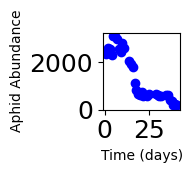

In [8]:
fig, ax = plt.subplots(figsize=(1, 1))

ax.set_ylim([0, 3233])

ax.plot(time_list, aphid_data.Density.values, 'o', c='b')
ax.set(xlabel='Time (days)')
plt.rc('axes', labelsize=20, titlesize=40),plt.xticks(fontsize=18),plt.yticks(fontsize=18)
plt.ylabel('Aphid Abundance')

{'k1': RBF(length_scale=10), 'k2': WhiteKernel(noise_level=5e-10), 'k1__length_scale': 10.000000000000002, 'k1__length_scale_bounds': (10, 100), 'k2__noise_level': 5.000000000000012e-10, 'k2__noise_level_bounds': (1e-10, 5e-10)}
Initial: RBF(length_scale=1) + WhiteKernel(noise_level=1)
Optimum: RBF(length_scale=10) + WhiteKernel(noise_level=5e-10)
Log-Marginal-Likelihood: -525176647.22261643


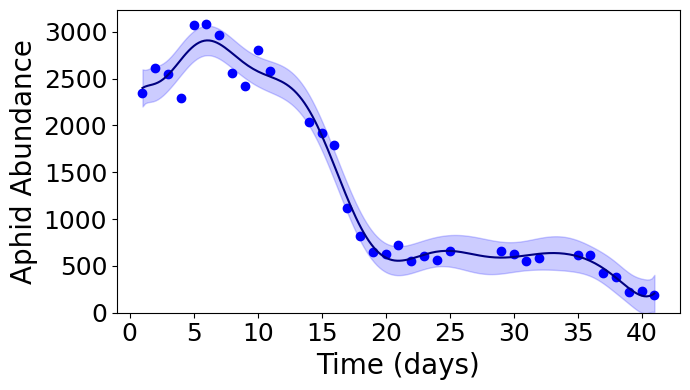

In [9]:
(mean_density, min_density, max_density) = regularize_data(time_list, aphid_density)
plot_data(time_list, aphid_density, mean_density, min_density, max_density)
plt.ylabel('Aphid Abundance')
plt.savefig("img/reg_aphid.png", dpi=300)

In [10]:
aphid_density = mean_density

In [11]:
t_list = time_list
t_list = np.linspace(t_list[0], t_list[-1], 200)

def regularize_data(time_list, density):
    kernel = ConstantKernel(constant_value_bounds = (1.0e-1, 1.0)) + WhiteKernel(noise_level_bounds = (1.0e-3, 1.0e-2))

    model = GaussianProcessRegressor(kernel=kernel, alpha=1.0e-10, n_restarts_optimizer=50, normalize_y=np.max(density))
    model.fit(time_list.reshape(-1, 1), density)
    target_pred = model.predict(t_list.reshape(-1, 1), return_std=True)
    
    print(str(model.kernel_.get_params()))
    print("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, model.kernel_,
             model.log_marginal_likelihood(model.kernel_.theta)))
    
    mean_density = target_pred[0]
    err = 1.96 * np.max(density) * target_pred[1]
    min_density = target_pred[0] - err
    max_density = target_pred[0] + err
    
    return (mean_density, min_density, max_density)

In [12]:
def plot_data(time_list, density, mean_density, min_density, max_density):
    fig, ax = plt.subplots(figsize=(7, 4))
    
    ax.plot(time_list, density, 'o', c='r')
    ax.plot(t_list, mean_density, c='#800000')
    
    plt.xlabel('Time (days)')
    
    ax.set_ylim([-0.2, 10])
    plt.rc('axes', labelsize=20, titlesize=40),plt.xticks(fontsize=18),plt.yticks(fontsize=18)
#    plt.xticks(color='w'),plt.yticks(color='w')

    fig.set_tight_layout(True)

    ax.fill_between(t_list,
                    min_density,
                    max_density,
                    alpha=0.2,
                    color='#FF6347')

{'k1': 0.316**2, 'k2': WhiteKernel(noise_level=0.01), 'k1__constant_value': 0.10000000000000006, 'k1__constant_value_bounds': (0.1, 1.0), 'k2__noise_level': 0.010000000000000005, 'k2__noise_level_bounds': (0.001, 0.01)}
Initial: 1**2 + WhiteKernel(noise_level=1)
Optimum: 0.316**2 + WhiteKernel(noise_level=0.01)
Log-Marginal-Likelihood: -1655.8719413708159


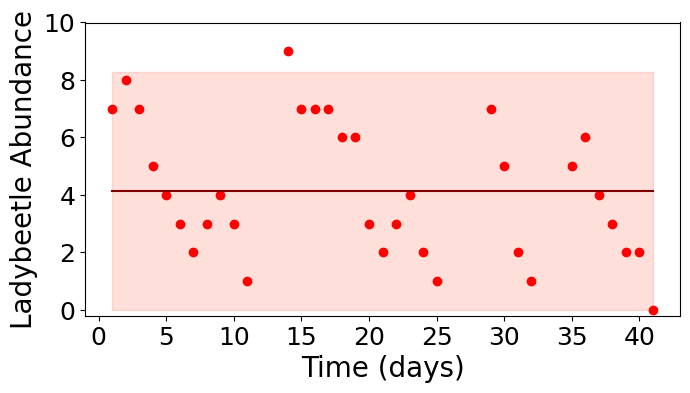

In [13]:
(mean_density, min_density, max_density) = regularize_data(time_list, ladybeetle_density)
plot_data(time_list, ladybeetle_density, mean_density, min_density, max_density)
plt.ylabel('Ladybeetle Abundance')
plt.savefig("img/reg_ladybeetle.png", dpi=300)

In [14]:
ladybeetle_density = mean_density

In [15]:
aphid_ic = aphid_density[0]
ladybeetle_ic = ladybeetle_density[0]

In [16]:
y0 = aphid_ic, ladybeetle_ic

y0

(2400.511917153086, 4.147058823529371)

In [17]:
time_list = t_list

# Model 1

In [18]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

y0 = aphid_ic, ladybeetle_ic

@jit(nopython=True)
def M01_model(
    t,
    X,
    r1 = 10,
    ef = 0.15,
    m = 1.5,
    a1 = 1,
    a2 = 1,
):
    """
    Pure Phenology model (M01) python implementation.
    """
    u, v = X
    u_prime = r1 * u - a1 * u * v / ( 1 + a2 * u  )
    v_prime = ef * u - m * v * v
    return u_prime, v_prime

def M01_ode_solver(
    y0,
    t_span,
    t_eval,
    r1 = 10,
    ef = 0.15,
    m = 1.5,
    a1 = 1,
    a2 = 1,
):
    solution_ODE = solve_ivp(
        fun=M01_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r1,ef,m,a1,a2),
        method="Radau",
    )
    return solution_ODE

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, len(time_list))

u_data = aphid_density
v_data = ladybeetle_density

(200,)


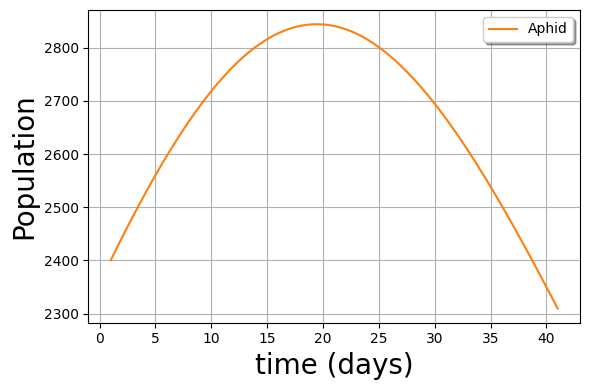

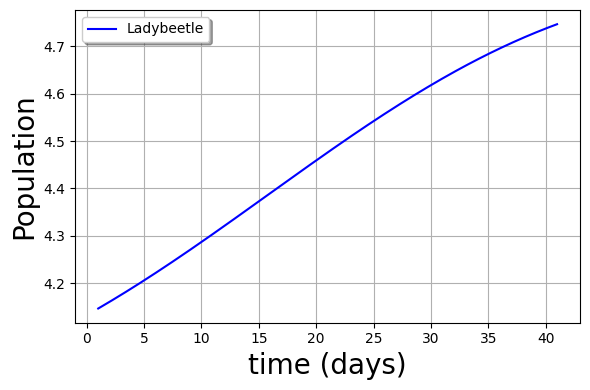

In [19]:
# Testing

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, len(time_list))

r1=0.25
ef=1.1387777257314906e-05
m=0.0007717188879990568
a1=0.058997163
a2=2.3079205719709543e-16

r1=r1*1.05
ef=ef
m=m
a1=a1
a2=a2

solution_ODE = M01_ode_solver(y0,(t0, tf + days_to_forecast),time_list_range,r1=r1,ef=ef,m=m,a1=a1,a2=a2)
t_computed, y_computed = solution_ODE.t, solution_ODE.y
aphid_analytic, ladybeetle_analytic = y_computed

print(aphid_analytic.shape)

plt.figure(figsize=(6, 4))

#plt.axhline(y=vfix, color='blue', linestyle='-')
plt.plot(time_list_range, aphid_analytic, label="Aphid", linestyle="-", markersize=10,color="#ff7f0e")

plt.xlabel("time (days)")
plt.ylabel("Population")
plt.legend(fancybox=True, shadow=True)
plt.grid()

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))

#plt.axhline(y=vfix, color='blue', linestyle='-')
plt.plot(time_list_range, ladybeetle_analytic, label="Ladybeetle", linestyle="-", markersize=10,color="blue")

plt.xlabel("time (days)")
plt.ylabel("Population")
plt.legend(fancybox=True, shadow=True)
plt.grid()

plt.tight_layout()
plt.show()

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [20]:
def M01_least_squares_error_ode(
    par, time_list_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_list_span = (time_list_exp.min(), time_list_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_list_span, time_list_exp, *args)
        simulated_time_list = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [21]:
from scipy import optimize

seed=seed

r1=0.25
ef=0.00028572670084507304
m=0.0090299289466087
a1=0.057879555878958946
a2=0.0001854147178848756
denom_min = 0.1
denom_max = 1.9
bounds_M01 = [
    ( ( r1 ), ( r1 ) ),
    ( ( ef * denom_min ), ( ef * denom_max ) ),
    ( ( m * denom_min ), ( m * denom_max ) ),
    ( ( a1 * denom_min ), ( a1 * denom_max ) ),
    ( ( a2 * denom_min ), ( a2 * denom_max ) ),
]

result_M01 = optimize.differential_evolution(
    M01_least_squares_error_ode,
    bounds=bounds_M01,
    args=(
        time_list,
        [aphid_density, ladybeetle_density],
        M01_ode_solver,
        y0,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=10000,
    polish=True,
    disp=True,
    seed=seed,
    callback=callback_de,
    workers=-1,
)

print(result_M01)

differential_evolution step 1: f(x)= 5.88519e+06
parameters = [2.50000000e-01 1.53699305e-04 2.73623441e-03 5.01563466e-02
 6.51899678e-05]

differential_evolution step 2: f(x)= 5.88519e+06
parameters = [2.50000000e-01 1.53699305e-04 2.73623441e-03 5.01563466e-02
 6.51899678e-05]

differential_evolution step 3: f(x)= 4.299e+06
parameters = [2.50000000e-01 1.75477094e-04 5.29993358e-03 5.29917628e-02
 9.00001592e-05]

differential_evolution step 4: f(x)= 3.97144e+06
parameters = [2.50000000e-01 2.02564719e-04 5.54231999e-03 5.33406043e-02
 1.14802933e-04]

differential_evolution step 5: f(x)= 3.81198e+06
parameters = [2.50000000e-01 2.88329648e-04 7.51895685e-03 4.99890464e-02
 1.18809019e-04]

differential_evolution step 6: f(x)= 3.50278e+06
parameters = [2.50000000e-01 2.58216286e-04 8.49856019e-03 5.64899400e-02
 1.55020426e-04]

differential_evolution step 7: f(x)= 3.38715e+06
parameters = [2.50000000e-01 2.53672430e-04 7.83418785e-03 5.62146273e-02
 1.55269603e-04]

differential_ev

* Retrieving the calibrated parameter values:

In [22]:
t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r1_deterministic,
    ef_deterministic,
    m_deterministic,
    a1_deterministic,
    a2_deterministic,
) = result_M01.x

solution_ODE_M01 = M01_ode_solver(
    y0,
    (t0, tf + days_to_forecast), 
    time_list_range, 
    *result_M01.x
)
t_computed_M01, y_computed_M01 = solution_ODE_M01.t, solution_ODE_M01.y
u_M01, v_M01 = y_computed_M01

parameters_dict = {
    "Model": "M01",
    u"$r1$": r1_deterministic,
    u"$ef$": ef_deterministic,
    u"$m$": m_deterministic,
    u"$a1$": a1_deterministic,
    u"$a2$": a2_deterministic,
}

print("r1=" + str(r1_deterministic) + "\n" + "ef=" + str(ef_deterministic) + "\n" + "m=" + str(m_deterministic) + "\n" + "a1=" + str(a1_deterministic) + "\n" + "a2=" + str(a2_deterministic) )

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])

r1=0.25
ef=0.000289735490220924
m=0.009319761797967717
a1=0.05889354826648396
a2=0.00019481734189958548


#### Simulation

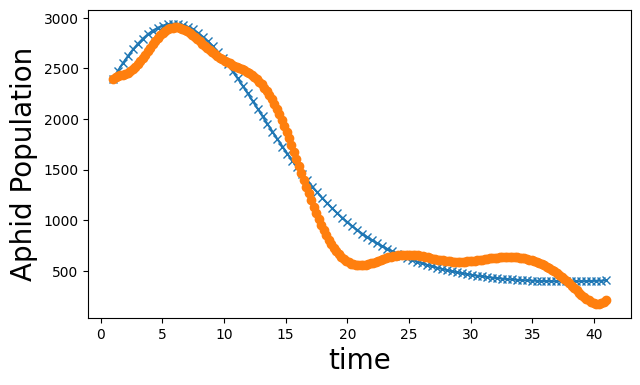

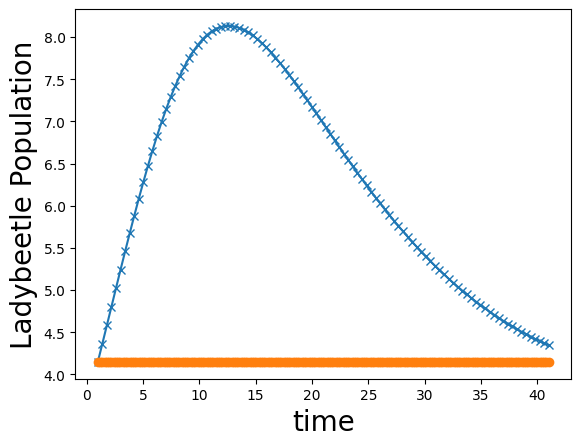

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_M01, u_M01, '-x')
plt.plot(time_list, aphid_density, 'o', label='Observed')

plt.xlabel('time')
plt.ylabel('Aphid Population')
plt.show()

plt.plot(t_computed_M01, v_M01, '-x')
plt.plot(time_list, ladybeetle_density, 'o', label='Observed')
plt.xlabel('time')
plt.ylabel('Ladybeetle Population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [24]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    ef,
    m,
    a1,
    a2,
]
factors_names = [
    r"$r1$",
    r"$ef$",
    r"$m$",
    r"$a1$",
    r"$a2$",
]
params_perturbations = 0.05
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=True, seed=seed)

In [25]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = M01_least_squares_error_ode(
        parameters_realization,
        time_list,
        [u_data, v_data],
        M01_ode_solver,
        y0
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 355.06it/s]


In [26]:
from SALib.analyze.morris import analyze as ee_analyze

data_time_list = time_list
num_of_experimental_points = data_time_list.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

,$\mu^*$
$a1$,0.366604
$r1$,0.33547
$ef$,0.115389
$m$,0.09681
$a2$,0.085727


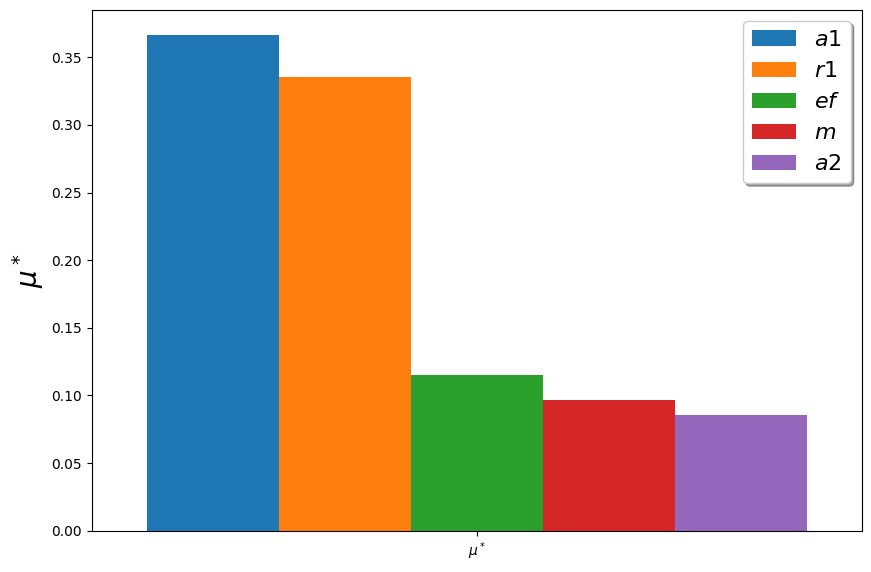

In [27]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

### Prey (pest) population

In [28]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    ef,
    m,
    a1,
    a2,
]
factors_names = [
    r"$r1$",
    r"$ef$",
    r"$m$",
    r"$a1$",
    r"$a2$",
]
params_perturbations = 0.05
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=True, seed=seed)

In [29]:
from tqdm import tqdm

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_list_points = time_list_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_list_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_M01 = M01_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_list_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_M01.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 329.44it/s]


In [30]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_Si['time_list'] = time_list_range
df_sigmai['time_list'] = time_list_range
for time_list_point in tqdm(range(num_of_time_list_points)):
    Si = ee_analyze(
        problem_info, 
        parameter_values, 
        qoi_sensitivity_outputs[:, time_list_point], 
        num_levels=grid_level, 
        seed=seed
    )
    # Some parameters combinations may result in simulation failure.
    # This "if" skip such cases, since they do not have associated sensitivity indicies
    if np.isnan(Si["mu"][-1]):
        continue
        
    Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
    sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
    for idx, param_name in enumerate(problem_info['names']):
        df_Si.loc[time_list_point, param_name] = Si['mu_star_normalized'][idx]
        df_sigmai.loc[time_list_point, param_name] = sigmai_normalized[idx]

df_Si.dropna(inplace=True)  # remove values that calculation was not possible
df_Si.sort_values(by='time_list', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='time_list', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_time_lists = df_Si.time_list.values
df_Si

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 600.82it/s]


,time_list,$r1$,$ef$,$m$,$a1$,$a2$
0,1.404040,0.520425,0.011687,0.002644,0.35239,0.112854
1,1.808081,0.507015,0.022631,0.005246,0.351336,0.113773
2,2.212121,0.494793,0.03255,0.007694,0.350272,0.11469
3,2.616162,0.48251,0.042609,0.010288,0.349057,0.115535
4,3.020202,0.470402,0.051855,0.012894,0.348455,0.116393
...,...,...,...,...,...,...
94,39.383838,0.227504,0.129639,0.271922,0.36564,0.005294
95,39.787879,0.229388,0.128284,0.272823,0.364023,0.005481
96,40.191919,0.231277,0.126924,0.273604,0.362337,0.005858
97,40.595960,0.233213,0.125583,0.27432,0.360661,0.006222


In [31]:
df_sigmai

,time_list,$r1$,$ef$,$m$,$a1$,$a2$
0,1.404040,0.079258,0.013412,0.004754,0.527992,0.374584
1,1.808081,0.146949,0.017598,0.009122,0.500667,0.325664
2,2.212121,0.202144,0.021518,0.015087,0.477381,0.28387
3,2.616162,0.246294,0.02317,0.021266,0.461994,0.247275
4,3.020202,0.278002,0.028869,0.024199,0.461311,0.20762
...,...,...,...,...,...,...
94,39.383838,0.183634,0.090142,0.215045,0.465221,0.045959
95,39.787879,0.186047,0.0896,0.216883,0.463627,0.043843
96,40.191919,0.18853,0.089077,0.218659,0.461978,0.041756
97,40.595960,0.19105,0.088572,0.220389,0.46029,0.039699


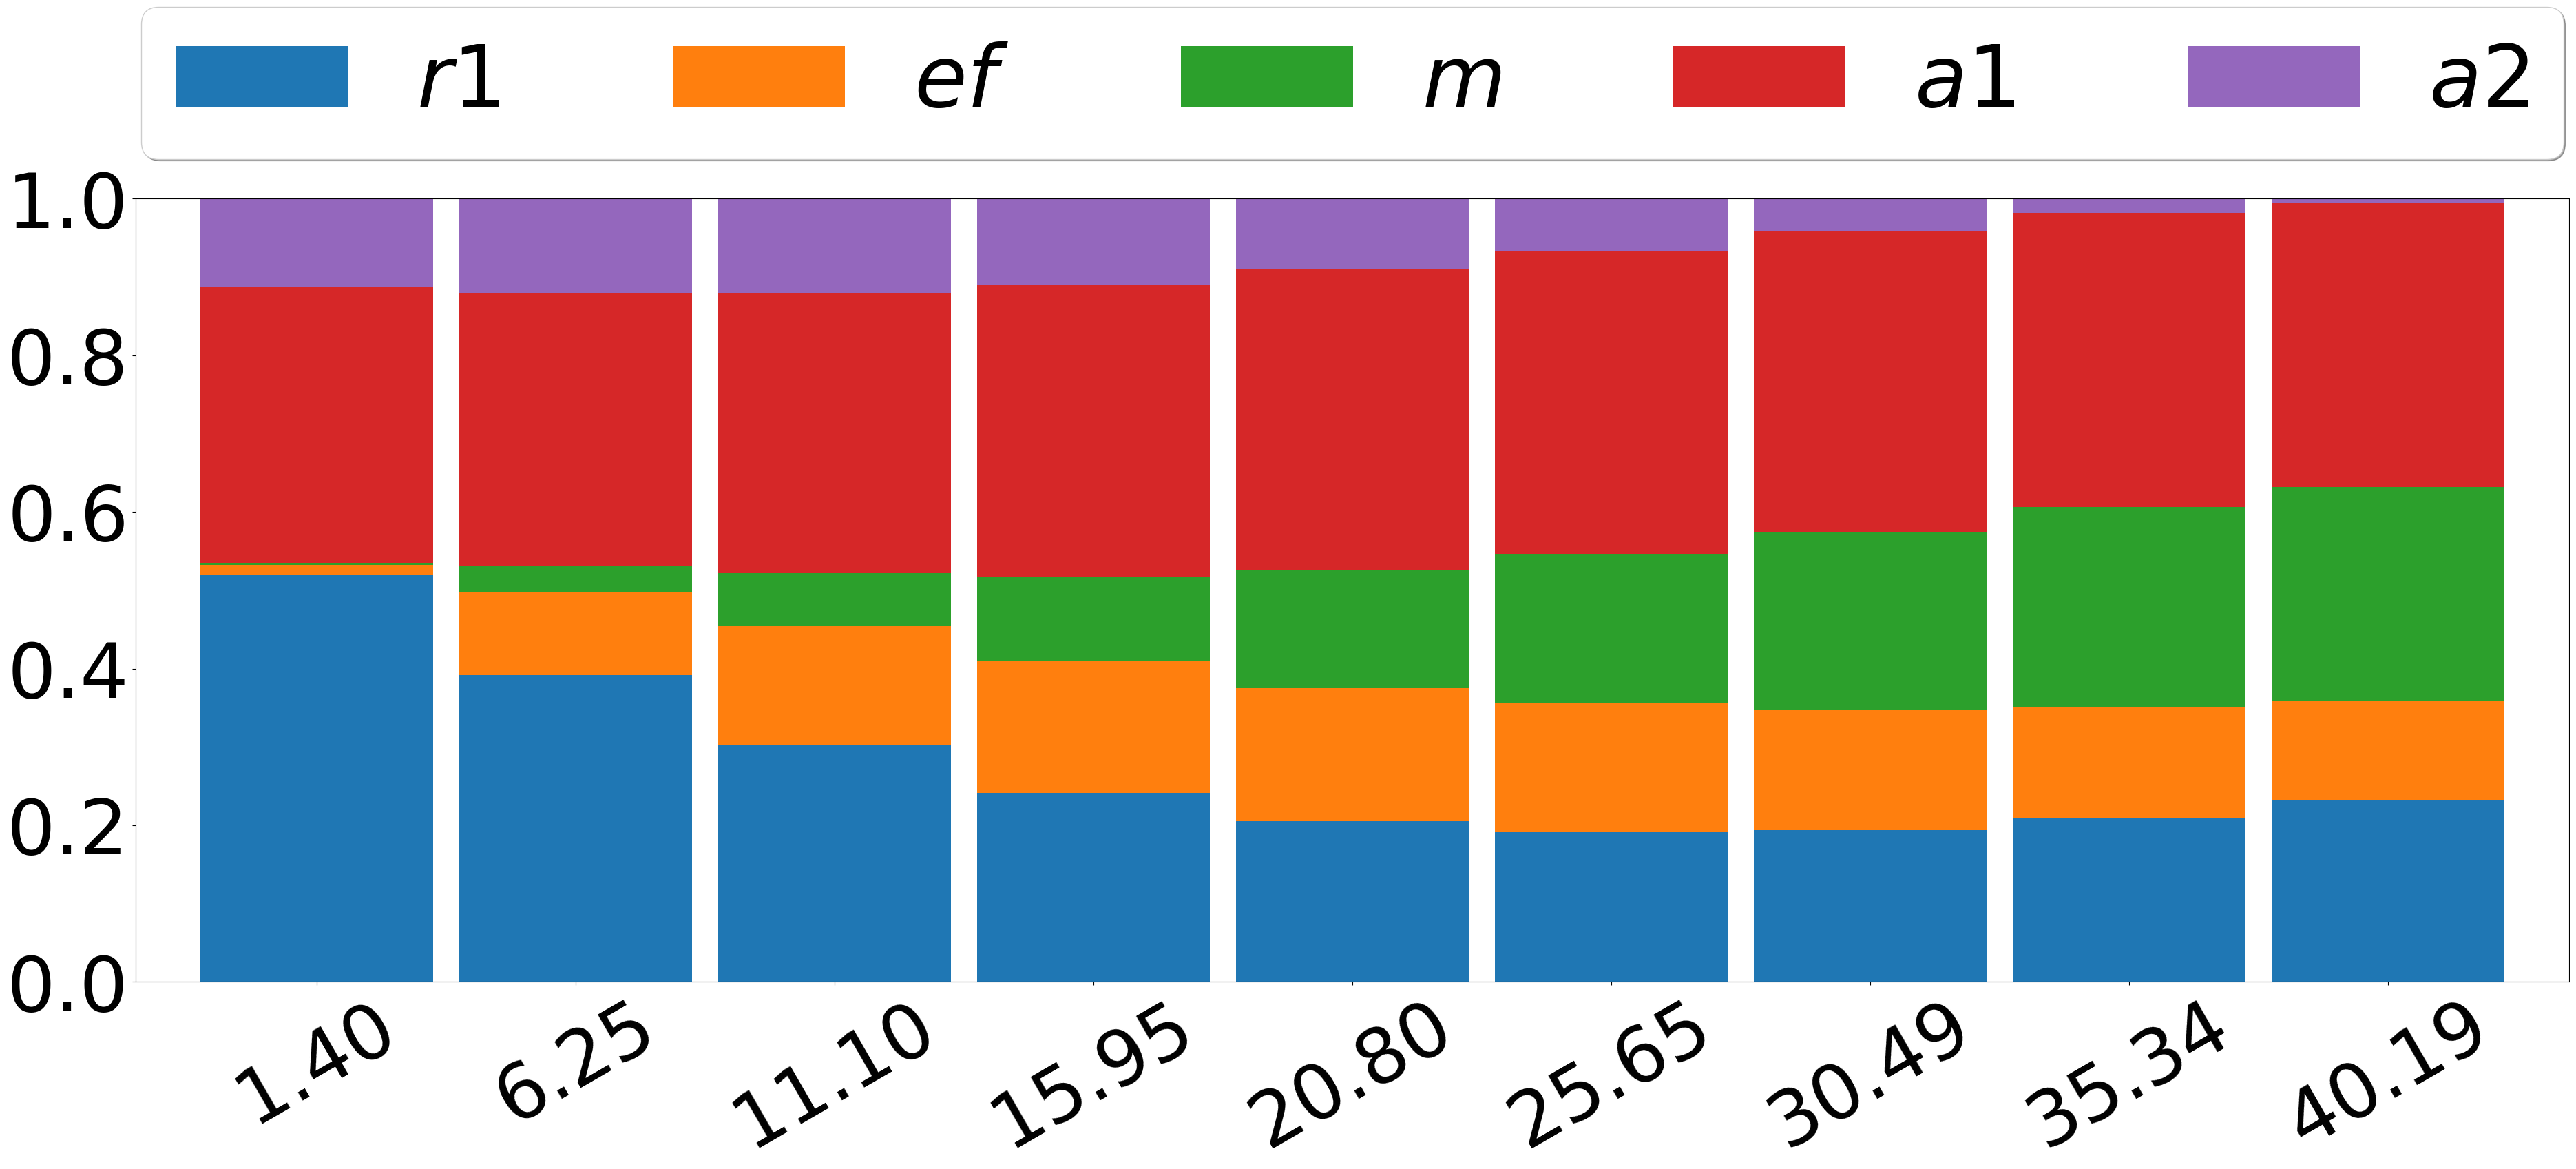

In [32]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 12
valid_time_lists_to_plot_mu = valid_time_lists[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='time_list', rot=30, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_mu[x]:.2f}")
#plt.xlabel("Time (days)", fontsize = 80), plt.ylabel(r"Normalized $\mu^*$", fontsize = 80), plt.xticks(fontsize=80), plt.yticks(fontsize=80)
plt.xlabel("", fontsize = 80), plt.ylabel("", fontsize = 80), plt.xticks(fontsize=80), plt.yticks(fontsize=80)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=90)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_M01.png", dpi=50)
plt.show()

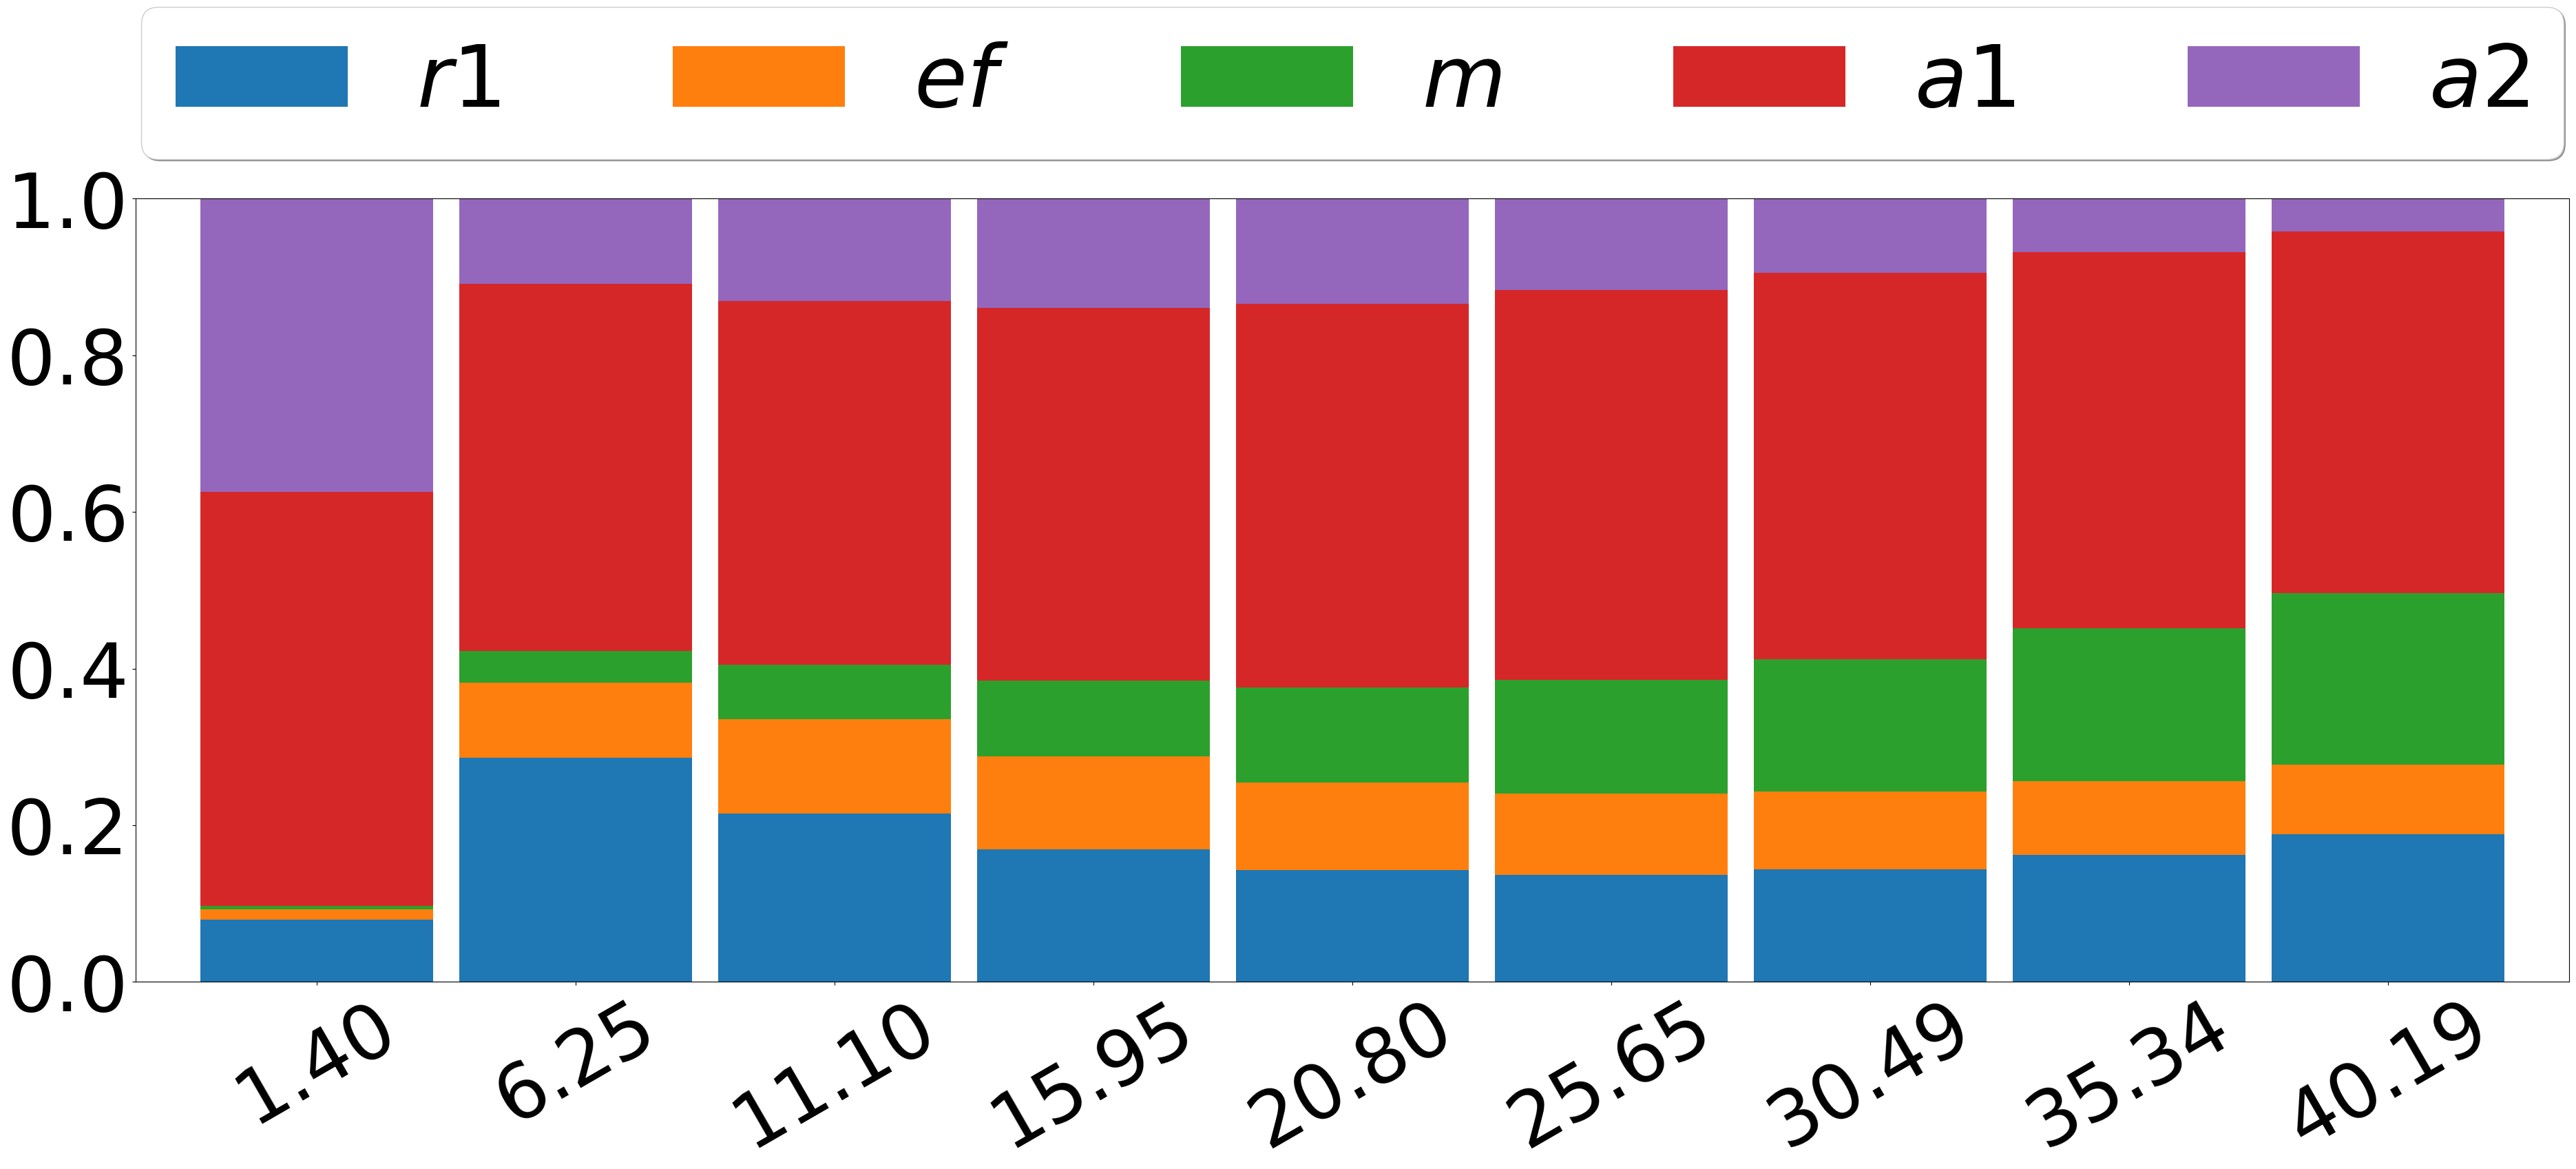

In [33]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 12
valid_time_lists_to_plot_sigma = valid_time_lists[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='time_list', rot=30, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_sigma[x]:.2f}")
#plt.xlabel("Time (days)", fontsize = 80), plt.ylabel(r"Normalized $\sigma$", fontsize = 80), plt.xticks(fontsize=80), plt.yticks(fontsize=80)
plt.xlabel("", fontsize = 80), plt.ylabel("", fontsize = 80), plt.xticks(fontsize=80), plt.yticks(fontsize=80)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=90)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_M01.png", dpi=50)
plt.show()

## Bayesian calibration

In [34]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r1
        t.dscalar,  # ef
        t.dscalar,  # m
        t.dscalar,  # a1
        t.dscalar,  # a2
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def M01_ode_wrapper(time_list_exp, r1, ef, m, a1, a2, u0, v0):
    time_list_span = (time_list_exp.min(), time_list_exp.max())

    args = [r1, ef, m, a1, a2]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        M01_model, 
        time_list_span, 
        initial_conditions, 
        t_eval=time_list_exp, 
        method='Radau',
        args=args
    )
    simulated_time_list = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [35]:
observed_aphids = aphid_density.astype(np.float64)
observed_ladybeetles = ladybeetle_density.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = time_list.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
start_time = time.time()
denom_min = 0.95
denom_max = 1.05

with pm.Model() as fine_model_M01:
    # Prior distributions for the model's parameters
    r1_ = pm.Uniform(
        "r1",
        lower=( r1 * denom_min ),
        upper=( 1.5 * r1 * denom_max ),
   )
    ef_ = pm.Data("ef", ef)
    m_ = pm.Uniform(
        "m",
        lower=( 1.1 * m * denom_min ),
        upper=( 1.5 * m * denom_max ),
   )
    a1_ = pm.Uniform(
        "a1",
        lower=( a1 * denom_min ),
        upper=( 1.6 * a1 * denom_max ),
   )
    a2_ = pm.Data("a2", a2)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=300, shape=2)  # note 'shape' here

    # Wrapper for time_list. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "M01_model",
        M01_ode_wrapper(
            time_calibration,
            r1_,
            ef_,
            m_,
            a1_,
            a2_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
    r1_ = pm.Uniform(
        "r1",
        lower=( r1 * denom_min ),
        upper=( 1.5 * r1 * denom_max ),
   )
    ef_ = pm.Data("ef", ef)
    m_ = pm.Uniform(
        "m",
        lower=( 1.1 * m * denom_min ),
        upper=( 1.5 * m * denom_max ),
   )
    a1_ = pm.Uniform(
        "a1",
        lower=( a1 * denom_min ),
        upper=( 1.6 * a1 * denom_max ),
   )
    a2_ = pm.Data("a2", a2)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=300, shape=2)  # note 'shape' here

    # Wrapper for time_list. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "M01_model",
        M01_ode_wrapper(
            time_calibration,
            r1_,
            ef_,
            m_,
            a1_,
            a2_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )


with fine_model_M01:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
    trace_calibration_M01 = pm.sample(draws=6000, chains=6, cores=6, tune=2000, step=step, random_seed=seed)

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")


*** Performing Bayesian calibration ***
-- Running Monte Carlo simulations:


Multiprocess sampling (6 chains in 6 jobs)
MLDA: [std_deviation, a1, m, r1]


Sampling 6 chains for 2_000 tune and 6_000 draw iterations (12_000 + 36_000 draws total) took 876 seconds.
The number of effective samples is smaller than 10% for some parameters.


-- Monte Carlo simulations done in 16.921 minutes


100%|████████████████████████████████████████████| 4/4 [07:38<00:00, 114.65s/it]


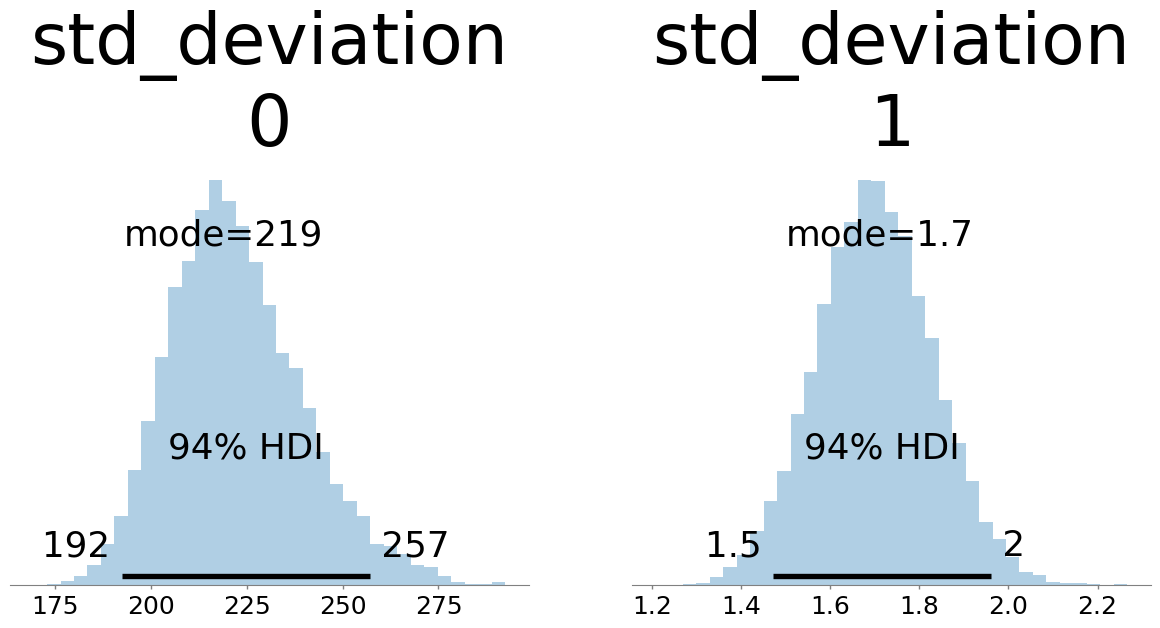

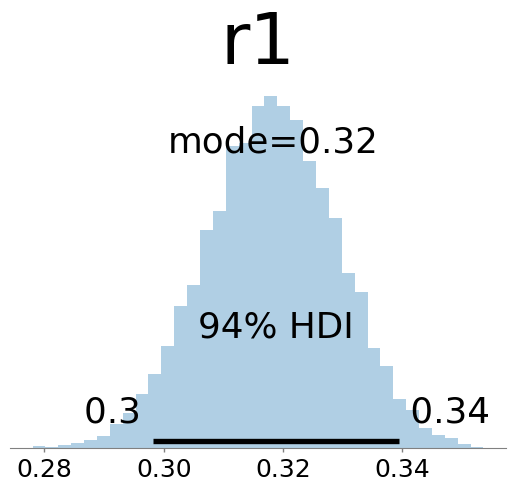

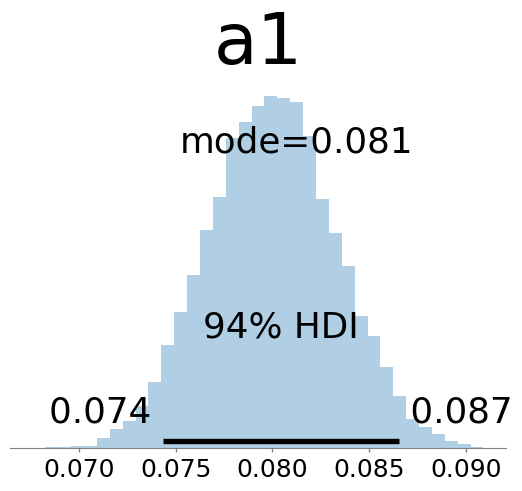

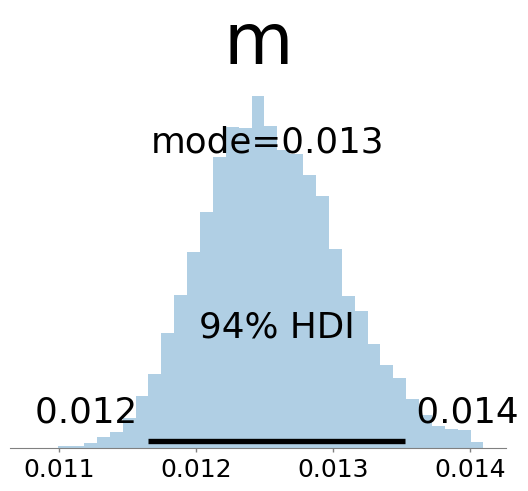

In [36]:
calibration_variable_names = [
    "std_deviation",
    "r1",
    "a1",
    "m",
]

plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_M01[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist",
        bins=35,
        round_to=None,
        textsize=18,
        point_estimate="mode"
    )
    plt.savefig(f"img/posterior_cal_M01_{variable}.png", bbox_inches='tight', pad_inches=0)

100%|████████████████████████████████████████████| 4/4 [07:14<00:00, 108.62s/it]


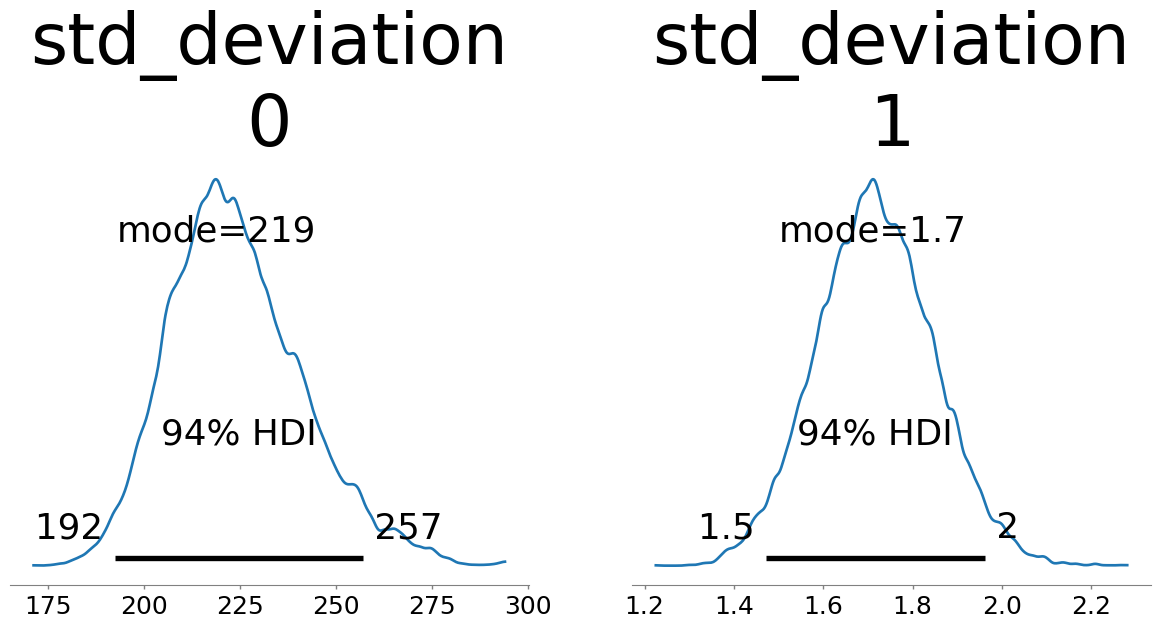

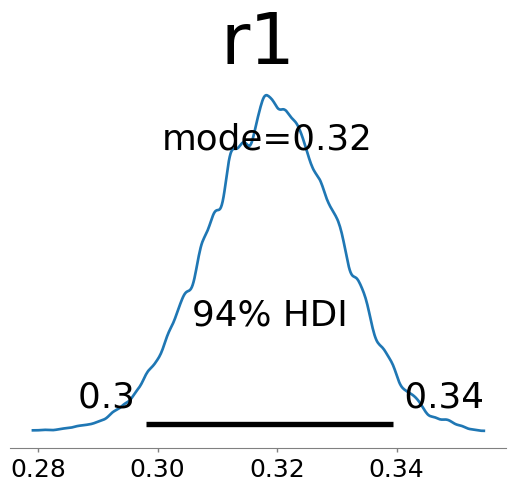

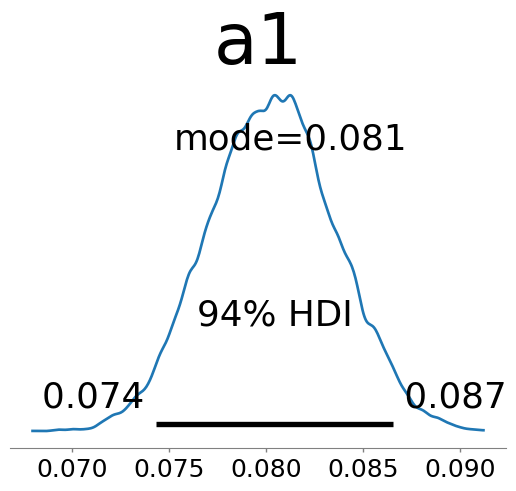

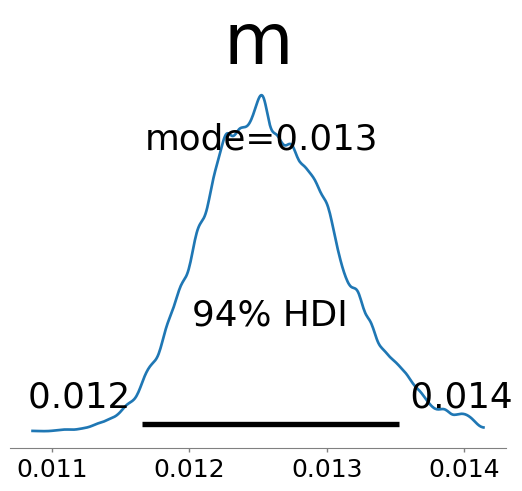

In [37]:
calibration_variable_names = [
    "std_deviation",
    "r1",
    "a1",
    "m",
]

plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_M01[::plot_step], 
        var_names=(f"{variable}"), 
        kind="kde",
        bins=35,
        round_to=None,
        textsize=18,
        point_estimate="mode"
    )
#    plt.savefig(f"img/posterior_cal_M01_KDE_{variable}.png", bbox_inches='tight', pad_inches=0)

Got error No model on context stack. trying to find log_likelihood in translation.


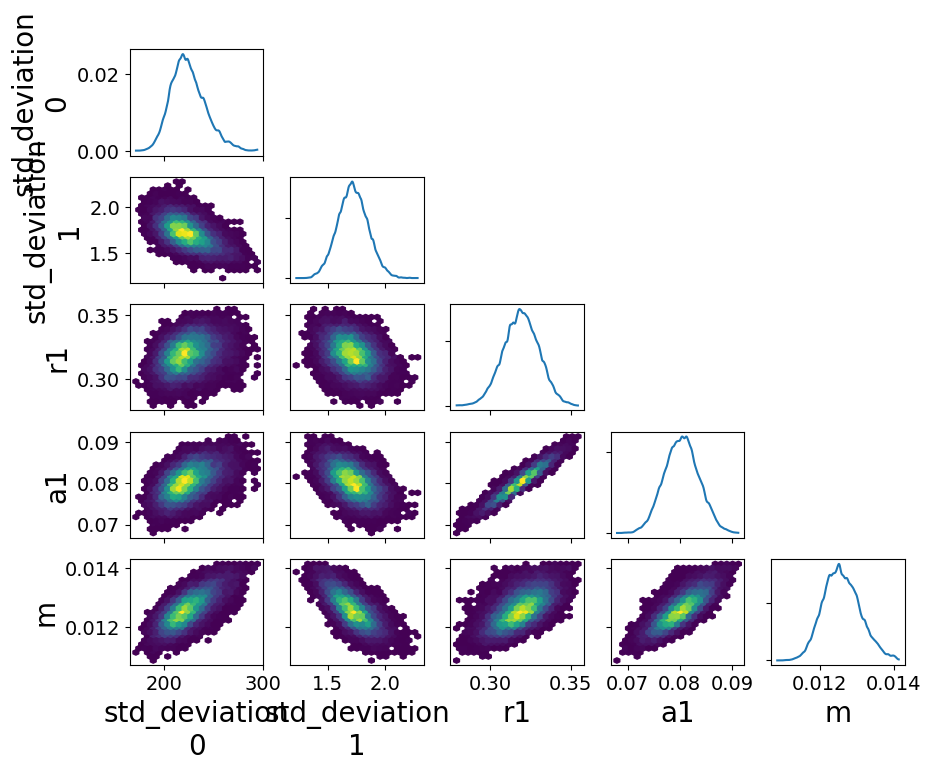

In [38]:
az.plot_pair(
    trace_calibration_M01,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal_M01.png")

In [39]:
df_stats_summary = az.summary(
    data=trace_calibration_M01,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # rounding level display
)

df_stats_summary

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%
std_deviation[0],224.177588,17.333311,192.388084,257.013965
std_deviation[1],1.716348,0.130601,1.471210,1.961733
r1,0.319159,0.011011,0.298123,0.339369
a1,0.080329,0.003277,0.074330,0.086534
m,0.012599,0.000499,0.011652,0.013524


Auxiliary functions to compute the Most Probable Value (MPV):

In [40]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calculating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [41]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_M01, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("csv/stats_summary_calibration_M01.csv")  # save in csv format

df_stats_summary

Calculating MPV from KDE for m: 100%|█████████████| 4/4 [00:47<00:00, 11.78s/it]


,mean,sd,hdi_3%,hdi_97%,mpv
std_deviation[0],224.177588,17.333311,192.388084,257.013965,218.723330
std_deviation[1],1.716348,0.130601,1.471210,1.961733,1.706734
r1,0.319159,0.011011,0.298123,0.339369,0.318752
a1,0.080329,0.003277,0.074330,0.086534,0.080779
m,0.012599,0.000499,0.011652,0.013524,0.012509


In [42]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_M01["M01_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_M01["M01_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_M01["M01_model"], 50, axis=0)

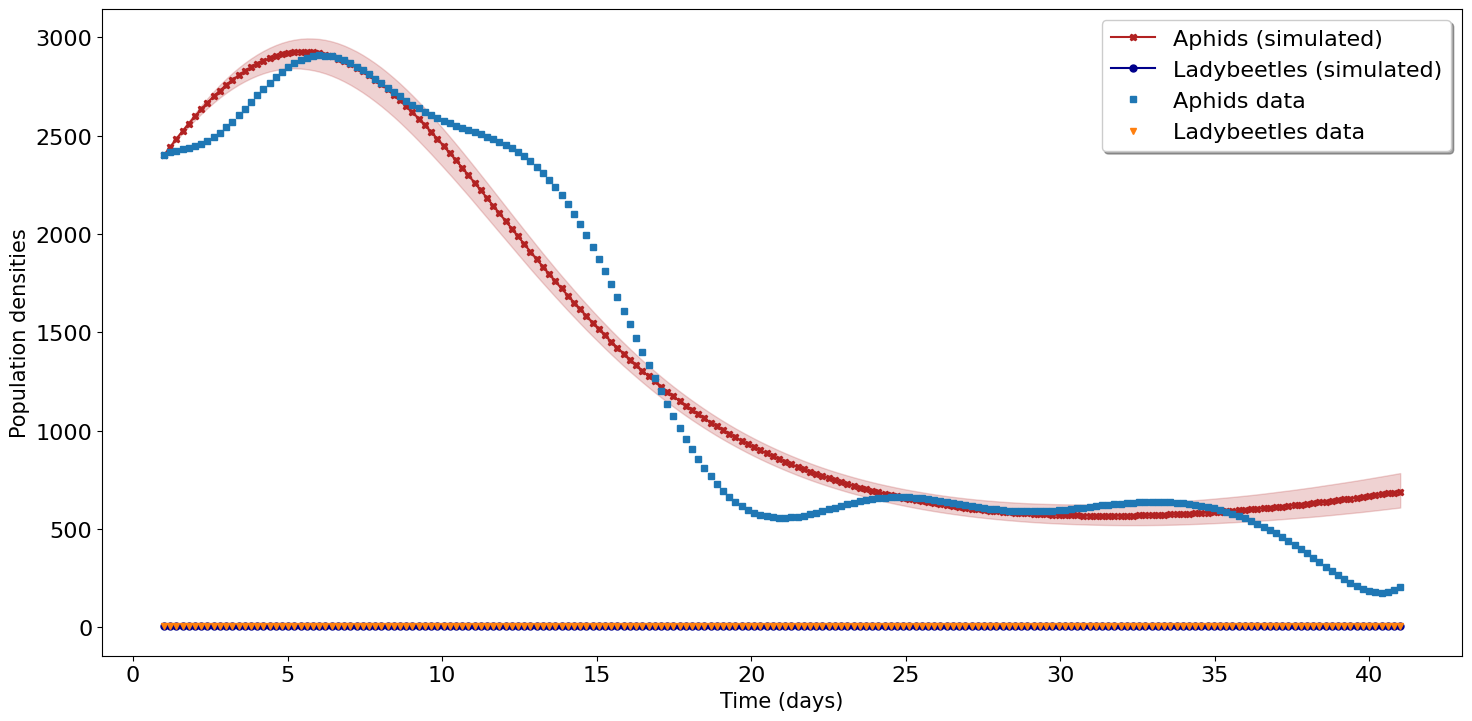

In [43]:
plt.figure(figsize=(15, 7.5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "firebrick",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=5,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="firebrick", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "darkblue",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=5,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="darkblue", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_density, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=5
)
plt.plot(
    time_observations, 
    ladybeetle_density, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=5
)

plt.legend(shadow=True)
plt.xlabel('Time (days)', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
plt.show()

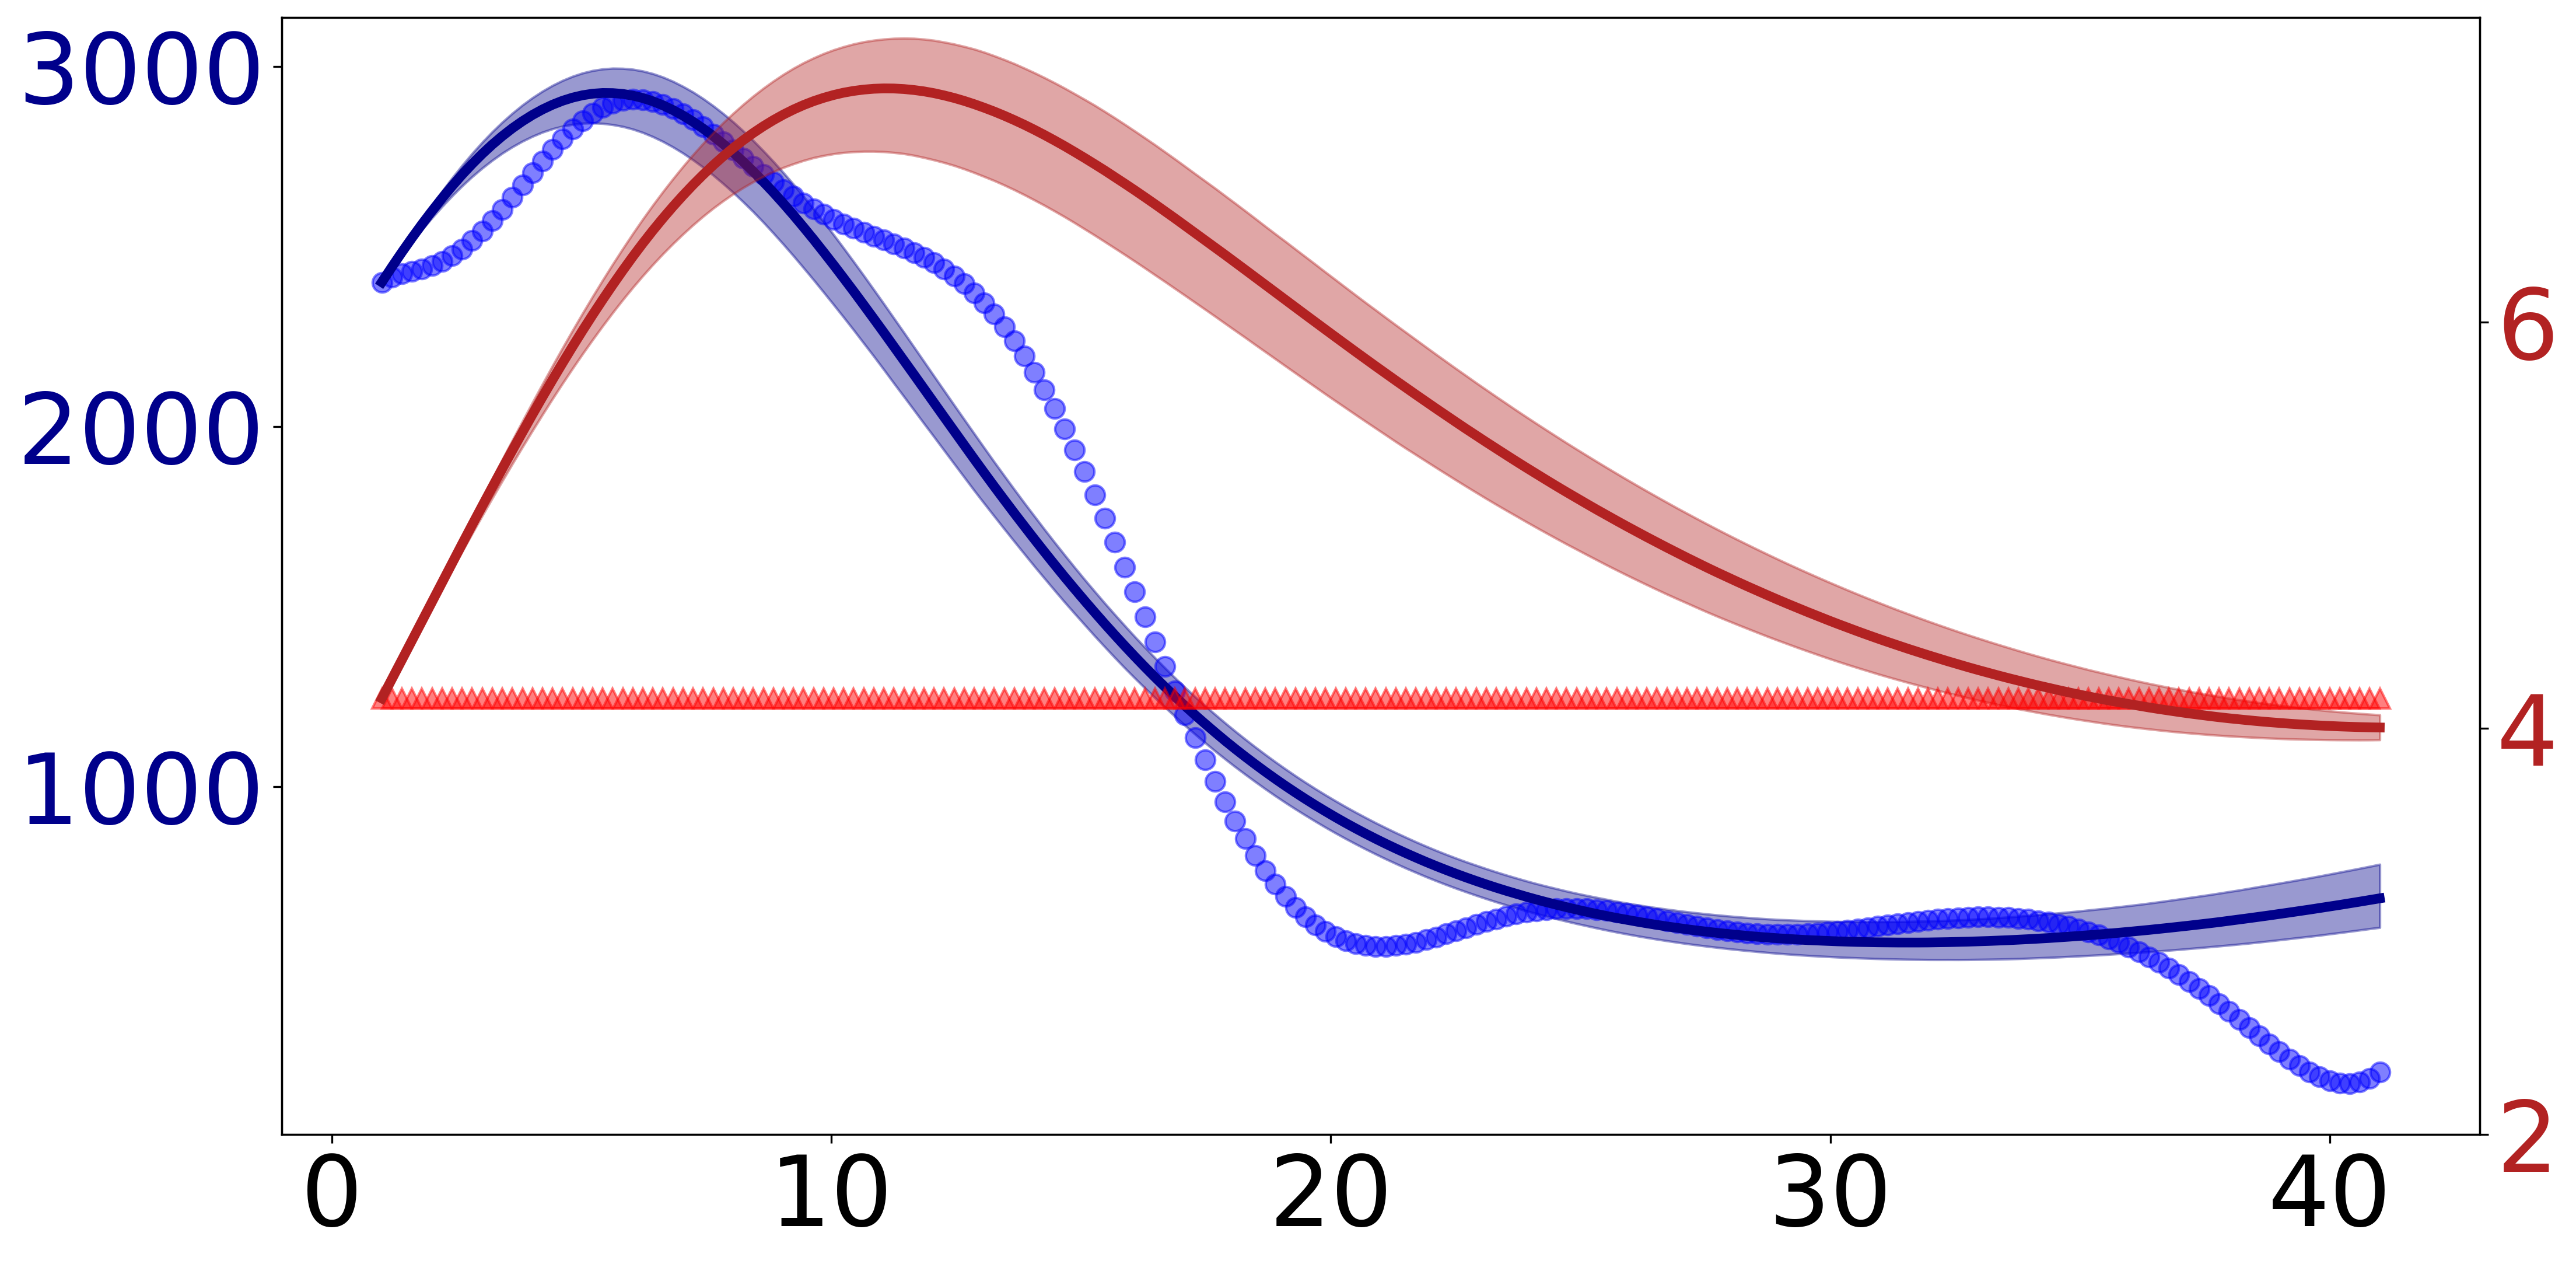

In [44]:
fig, ax1 = plt.subplots(1, 1, figsize = (15, 7.5), dpi = 300)
ax2 = ax1.twinx()
ax1.plot(time_observations, aphid_density, "bo", alpha = 0.5, markersize = 8)
ax2.plot(time_observations, ladybeetle_density, "r^", alpha = 0.5, markersize = 8)
ax1.plot(time_observations, y_fit[:, 0], "darkblue", alpha = 1.0, linewidth = 4)
ax2.plot(time_observations, y_fit[:, 1], "firebrick", alpha = 1.0, linewidth = 4)

ax1.fill_between(time_observations, y_min[:,0], y_max[:,0], color = "darkblue", alpha = 0.4)
ax2.fill_between(time_observations, y_min[:,1], y_max[:,1], color = "firebrick", alpha = 0.4)
#ax1.set_xlabel(r"Time (days)", fontsize=40)
#ax1.set_ylabel(r"Aphid", color = "darkblue", fontsize=40)
#ax2.set_ylabel(r"Ladybeetle", color = "firebrick", fontsize=40)
ax1.tick_params(axis = "y", labelcolor = "darkblue")
ax2.tick_params(axis = "y", labelcolor = "firebrick")
ax1.ticklabel_format(useOffset=False)
ax2.ticklabel_format(useOffset=False)

ax2.set_ylim([2, 7.5])

ax1.tick_params(labelsize=40)
ax2.tick_params(labelsize=40)

plt.tight_layout()
plt.savefig("img/calibration_M01.png", dpi=300)
plt.show()

In [45]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # save the realizations in a Python dictionary
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_M01.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("csv/calibration_realizations_M01.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

-- Exporting calibrated parameter to CSV


Gathering m realizations: 100%|█████████████████| 3/3 [00:00<00:00, 2021.35it/s]

-- Exported done in 0.095 seconds


In [46]:
df_realizations

,r1,a1,m
0,0.309894,0.077751,0.012337
1,0.313373,0.078820,0.012543
2,0.312721,0.078565,0.012551
3,0.315040,0.079171,0.012630
4,0.315040,0.079171,0.012630
...,...,...,...
35995,0.322286,0.081576,0.012756
35996,0.325339,0.082587,0.013071
35997,0.317116,0.079078,0.012358
35998,0.328352,0.083257,0.012892
